In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
comex_df=pd.read_csv('/home/andre301267/git/BD/temp/imp_fert_ncm_quanti.csv').sort_values(by=['CO_ANO','CO_MES'])

In [2]:
comex_df.nick.unique()

array(['MOP', 'MOP<60', 'NK', 'NPK', 'Nit.Sódio Potássico 15 15',
       'Outros N', 'Outros nitratos de sódio', 'SAM', 'SOP<52', 'MAP',
       'NAM', 'Nit.Sódio natural<16,3', 'Outros Nit.Sódio potássico',
       'Outros potássicos', 'Superfosfatos<22', 'UREIA',
       'DAP arsênio> 6 mg/kg', 'NCa', 'Outros SOP', 'PK',
       'Superfosfato>45', 'Ureia, mesmo aquosa',
       'Outros Nit.Sódio, naturais', 'NP', 'Nitratos e fosfatos',
       'Superfosfatos>35', 'Outros superfosfatos'], dtype=object)

In [3]:
uf='BA'
nick='NK'
comex_df=comex_df[(comex_df.UF==uf)&(comex_df.nick==nick)]\
.drop(columns=['UF','nick','CO_NCM','CO_PAIS','CO_URF','VL_SEGURO_orig','VL_FRETE_orig',\
               'VL_FOB_orig','VL_FRETE','VL_SEGURO'])

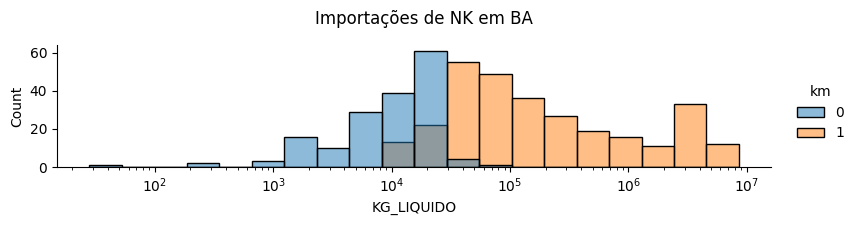

In [4]:
sns.displot(data=comex_df,x='KG_LIQUIDO',hue='km', log_scale=True,height=2,aspect=4).fig.suptitle(f"Importações de {nick} em {uf}",y=1.1)
plt.show()

In [5]:
km=int(input('Escolha o cluster (km) desejado:'))

Escolha o cluster (km) desejado: 1


In [6]:
comex_df=comex_df[comex_df.km==km]
comex_df.drop(columns='km',inplace=True)

In [7]:
comex_df=comex_df.groupby(by=['CO_ANO','CO_MES'])[['KG_LIQUIDO','VL_FOB']].sum().reset_index()\
.astype(int)

In [8]:
%run '/home/andre301267/git/BD/Comexstat/function/matriz_esparsa.ipynb'
comex_df_sp=matriz_esparsa(comex_df)

** Função matriz_esparsa(comex_df, ct) disponível **


In [9]:
%run '/home/andre301267/git/BD/Comexstat/function/escalona_tempo.ipynb'
comex_df_sc=escalona_tempo(comex_df_sp)

# Identifica a mês corrente
mês_corrente=comex_df_sc[comex_df_sc.CO_ANO==comex_df_sc.CO_ANO.max()].CO_MES.max()
# Completa escalonamento criano ano índice
comex_df_sc['ano_i']=comex_df_sc.CO_ANO.shift(mês_corrente)

** Função escalona_tempo(comex_df) disponível **


In [10]:
# Corrige na
k=comex_df_sc[comex_df_sc.ano_i.isna()]
w=comex_df_sc[~comex_df_sc.ano_i.isna()]
k=k.drop(columns='ano_i')
z=np.array(w[w.index.isin(k.index+8)].ano_i-1)
k['ano_i']=z
comex_df_sc=pd.concat([k,w])

In [11]:
# Corrige tipo
comex_df_sc[comex_df_sc.select_dtypes('float').columns]=comex_df_sc[comex_df_sc.select_dtypes('float').columns].astype(int)

In [12]:
# Identifica escalas
escalas=comex_df_sc.columns[-6:]
escalas

Index(['mes_i', 'bim_i', 'trim_i', 'quadri_i', 'sem_i', 'ano_i'], dtype='object')

In [13]:
list(enumerate(escalas))

[(0, 'mes_i'),
 (1, 'bim_i'),
 (2, 'trim_i'),
 (3, 'quadri_i'),
 (4, 'sem_i'),
 (5, 'ano_i')]

In [14]:
si=1

In [15]:
sc=escalas[si]

comex_df_sc_g=comex_df_sc.groupby(by=['ano_i',sc])[['KG_LIQUIDO','VL_FOB']].sum().reset_index().astype(int)

tab=comex_df_sc[['date','ano_i',sc]]
tab=tab.drop_duplicates(subset=['ano_i',sc])
tab=tab[tab.ano_i!=tab.ano_i.min()]

comex_df_sc_g=tab.merge(comex_df_sc_g)

g_a_sc_dict={'mes_i':12, 'bim_i':6, 'trim_i':4, 'quadri_i':3, 'sem_i':2}

g_i_sc_dict={'mes_i':1, 'bim_i':2, 'trim_i':3, 'quadri_i':4, 'sem_i':6}

l=len(comex_df_sc_g.columns)

In [16]:
g_a_sc_dict[sc]

6

In [17]:
comex_df_sc_g\
.insert(l,'mm_fob_'+sc,comex_df_sc_g.VL_FOB.rolling(g_a_sc_dict[sc]).sum())

In [18]:
comex_df_sc_g\
.insert(l,'mm_kg_'+sc,comex_df_sc_g.KG_LIQUIDO.rolling(g_a_sc_dict[sc]).sum())

comex_df_mm=comex_df_sc_g

comex_df_mm=comex_df_mm.dropna()

In [19]:
comex_df_mm=comex_df_mm.assign(fob_kg=comex_df_mm.VL_FOB/comex_df_mm.KG_LIQUIDO)

In [20]:
fob_kg_prev=comex_df_mm.fob_kg.tail(1).values[0]

In [21]:
comex_df_mm.fob_kg=comex_df_mm.fob_kg.shift(1)

In [22]:
comex_df_mm.head(1)

,date,ano_i,bim_i,KG_LIQUIDO,VL_FOB,mm_kg_bim_i,mm_fob_bim_i,fob_kg
5,2001-11-01,2001,2,0,0,207000.0,112876.0,NaN


In [23]:
X_train=comex_df_mm[['date','fob_kg']]

In [24]:
X_train.date=X_train.date.astype(int)

In [25]:
y_train=comex_df_mm[['mm_kg_'+sc,'mm_fob_'+sc]]

In [26]:
from datetime import timedelta
date_prev=comex_df_mm.date.iloc[-g_a_sc_dict[sc]] + timedelta(days=365+1)

In [27]:
X_prev=pd.DataFrame({
    'date':[date_prev],
    'fob_kg':[fob_kg_prev]})

X_prev.date=X_prev.date.astype(int)

In [28]:
#from sklearn.linear_model import LinearRegression as REG
from sklearn.ensemble import RandomForestRegressor as REG
REG=REG()
REG.fit(X_train,y_train)
X_prev[['mm_kg_'+sc,'mm_fob_'+sc]]=REG.predict(X_prev)

In [29]:
X_prev=X_prev\
.assign(tipo=['prev'])\
.assign(ano_i=[comex_df.CO_ANO.max()])\
.assign(KG_LIQUIDO=X_prev['mm_kg_'+sc]-comex_df_mm['mm_kg_'+sc].iloc[-1]+comex_df_mm.iloc[-g_a_sc_dict[sc],3])\
.assign(VL_FOB=    X_prev['mm_fob_'+sc]-comex_df_mm['mm_fob_'+sc].iloc[-1]+comex_df_mm.iloc[-g_a_sc_dict[sc],4])
X_prev.insert(0,str(sc),1)

In [30]:
comex_df_mm=pd.concat([comex_df_mm.assign(tipo='real'),X_prev])

In [31]:
comex_df_mm.date=pd.to_datetime(comex_df_mm.date)

In [32]:
comex_df_mm=comex_df_mm[comex_df_mm.date.dt.year>2019]

In [33]:
comex_df_mm['fob_kg'].iloc[-1]=comex_df_mm['VL_FOB'].iloc[-1]/comex_df_mm['KG_LIQUIDO'].iloc[-1]

In [34]:
comex_df_mm.tail(15)

,date,ano_i,bim_i,KG_LIQUIDO,VL_FOB,mm_kg_bim_i,mm_fob_bim_i,fob_kg,tipo
128,2022-05-01,2021,5,3988210.0,5842781.00,22132270.0,22780888.00,1.073607,real
129,2022-07-01,2021,6,4270350.0,6175497.00,26306620.0,28810333.00,1.465013,real
130,2022-09-01,2022,1,5699900.0,8135785.00,27705760.0,33585822.00,1.446134,real
131,2022-11-01,2022,2,169000.0,280768.00,23322760.0,30368988.00,1.427356,real
132,2023-01-01,2022,3,7758200.0,3275804.00,31069960.0,33570963.00,1.661349,real
133,2023-03-01,2022,4,3593000.0,4008627.00,25478660.0,27719262.00,0.422238,real
134,2023-05-01,2022,5,1210800.0,1195526.00,22701250.0,23072007.00,1.115677,real
135,2023-07-01,2022,6,3001600.0,2851295.00,21432500.0,19747805.00,0.987385,real
136,2023-09-01,2023,1,1644000.0,1455127.00,17376600.0,13067147.00,0.949925,real
137,2023-11-01,2023,2,2372000.0,2224004.00,19579600.0,15010383.00,0.885114,real


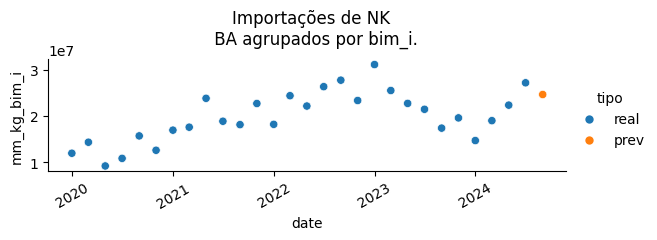

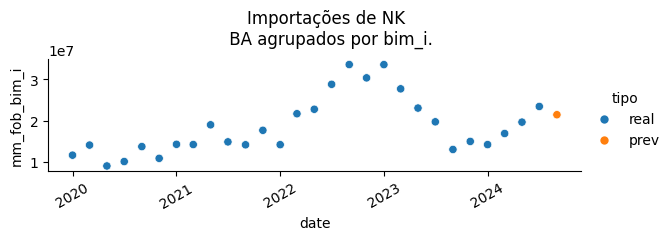

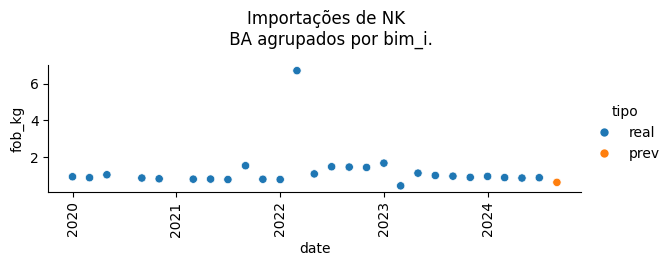

In [35]:
for cc in ['mm_kg_','mm_fob_','fob_kg']:
    kt='tipo'
    sct=sc
    if cc == 'fob_kg':
        sns.relplot(data=comex_df_mm,x='date',y=cc,height=2,aspect=3,hue='tipo')\
        .fig.suptitle(f"Importações de {nick} \n {uf} agrupados por {sc}.", y=1.2)
        plt.xticks(rotation=90)
        plt.show()
    else:
        sns.relplot(data=comex_df_mm,x='date',y=cc+str(sct),height=2,aspect=3, hue=kt)\
        .fig.suptitle(f"Importações de {nick} \n {uf} agrupados por {sc}.", y=1.1)
        plt.xticks(rotation=30)
        plt.show()